# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the terminal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="assets/pic1.png"/>

Then you will want to run the above command:

<img src="assets/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Data Exploration

In [32]:
!python -m pip install black isort

In [2]:
import sys
sys.version

'3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:53:15) [MSC v.1916 64 bit (AMD64)]'

In [9]:
%load_ext autoreload

import pathlib
import pandas as pd
import numpy as np
import math
import json

from IPython.display import display

%matplotlib inline

# read in the json files
data_dir = pathlib.Path('data')
files = {stem: data_dir / f"{stem}.json" 
         for stem in ('portfolio','profile', 'transcript')}
dataframes = {key: pd.read_json(file, orient='records', lines=True)
              for key, file in files.items()}
portfolio = dataframes.get("portfolio")
profile = dataframes.get("profile")
transcript = dataframes.get("transcript")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Exploration
### Review DataFrames

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### Review Transcript specifics

## Data Cleaning

The following cell will write a file into a local module and be loaded to clean
the dataframes before feature engineering will be performed. This will add
values to null that were coded as another value, expand nested data types into
columns; such as lists; categorize columns where appropriate, and convert
date columns into DateTime values.

In [8]:
%autoreload 2
from capstone_tools.data_cleaners import clean

In [10]:
clean_dataframes = {key: clean(df, key) for key, df in dataframes.items()}
portfolio = clean_dataframes['portfolio']
profile = clean_dataframes['profile']
transcript = clean_dataframes['transcript']

In [11]:
print('Portfolio:')
display(portfolio.head())
print('Profile:')
display(profile.head())
print('Transcript:')
display(transcript.head())

Portfolio:


,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


Profile:


,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


Transcript:


,person,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## Data Visualization

In [16]:
%autoreload 2
from capstone_tools.enums import Event

Comparing Advertising types - there appears to be even distribution of web, email, mobile, and social types and more BOGO and discount types over informational

### Portfolio Data

Comparing offers to difficulty and reward intensities, there is not an even
distribution, but does not appear to be skewed, the log data will need to be compared to evaluate if this is true.

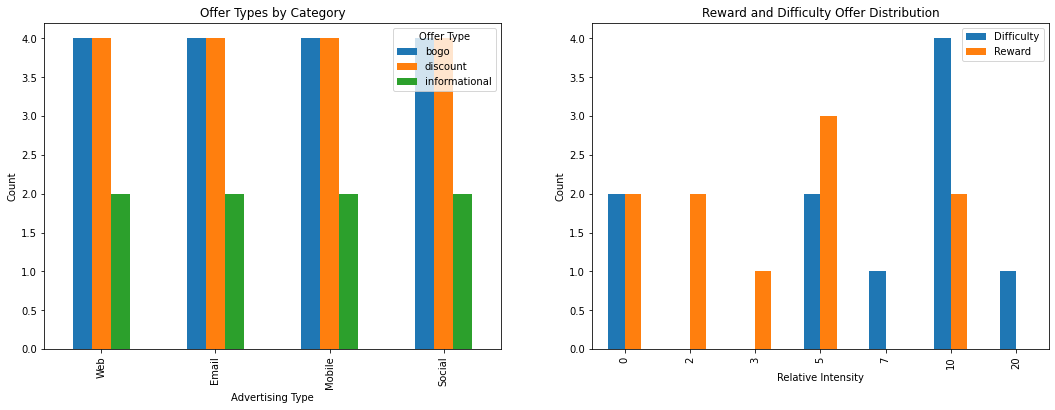

In [19]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(18,6))

(
    portfolio
    .rename(columns=lambda x: x.title().replace('_', ' '))
    .groupby('Offer Type')
    .count()
    [['Web', 'Email','Mobile', 'Social']]
    .T
    .plot(
        kind='bar',
        xlabel='Advertising Type',
        ylabel='Count',
        ax=axs[0],
        title='Offer Types by Category',
    )
);
(
    pd.concat(objs=(
        portfolio.groupby('difficulty').count()[['reward']].rename(columns=lambda _: 'Difficulty'),
        portfolio.groupby('reward').count()[['difficulty']].rename(columns=lambda _: 'Reward')
    ), axis=1).plot(
        kind='bar',
        ax=axs[1],
        xlabel='Relative Intensity',
        ylabel='Count',
        title='Reward and Difficulty Offer Distribution')
);

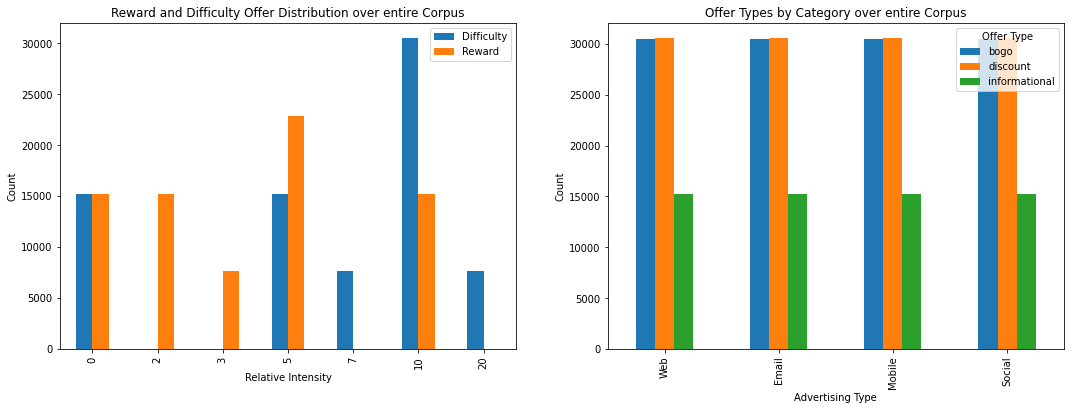

In [20]:
def plot_offers_metrics(transcript: pd.DataFrame, portfolio: pd.DataFrame):
    offers_sent = (
        pd.merge(
            transcript,
            portfolio,
            left_on='offer_id',
            right_on='id'
        )
        .query(f'event == "{Event.received}"')
    )

    fig, axs = plt.subplots(1, 2, figsize=(18,6))

    (
        pd.concat(objs=(
            offers_sent.groupby('difficulty').count()[['reward_y']].rename(columns=lambda _: 'Difficulty'),
            offers_sent.groupby('reward_y').count()[['difficulty']].rename(columns=lambda _: 'Reward')
        ), axis=1).plot(
            kind='bar',
            ax=axs[0],
            xlabel='Relative Intensity',
            ylabel='Count',
            title='Reward and Difficulty Offer Distribution over entire Corpus')
    )

    (
        offers_sent
        .rename(columns=lambda x: x.title().replace('_', ' '))
        .groupby('Offer Type')
        .count()
        [['Web', 'Email','Mobile', 'Social']]
        .T
        .plot(
            kind='bar',
            xlabel='Advertising Type',
            ylabel='Count',
            ax=axs[1],
            title='Offer Types by Category over entire Corpus',
        )
    );
    return fig, axs

plot_offers_metrics(transcript, portfolio);

Reviewing the entire corpus, the distribution appears to be the same.

### Profile Data

The profile data is a bit more ticky, nans exist within this dataset and some information will have to be provided as an additional category. Looking at Gender and age distributions there is a significant portion of nan values. As well as a significant skew in gender category:

In [21]:
print(f"Number of Profiles: {len(profile)}")
print(f"Number of Complete Profiles: {len(profile.dropna())}")


Number of Profiles: 17000
Number of Complete Profiles: 14825


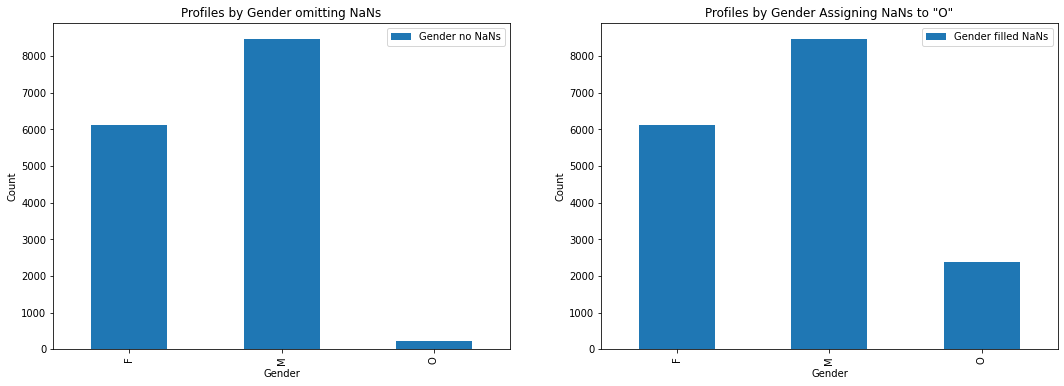

In [41]:
def plot_gender(profile: pd.DataFrame):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))

    (
        profile
        # .assign(gender=lambda df: df['gender'].fillna('O'))
        .groupby('gender')
        .count()
        [['id']]
        .rename(columns=lambda _: 'Gender no NaNs')
        .plot(
            kind='bar',
            xlabel='Gender',
            ylabel='Count',
            ax=axs[0],
            title='Profiles by Gender omitting NaNs',
        )
    );
    (
        profile
        .assign(gender=lambda df: df['gender'].fillna('O'))
        .groupby('gender')
        .count()
        [['id']]
        .rename(columns=lambda _: 'Gender filled NaNs')
        .plot(
            kind='bar',
            xlabel='Gender',
            ylabel='Count',
            ax=axs[1],
            title='Profiles by Gender Assigning NaNs to "O"',
        )
    )
    return fig, axs

plot_gender(profile);

There is significant skew in gender where Male is the most common followed by
female and other is a significant minor population - much lower than the profiles omitting gender all together.

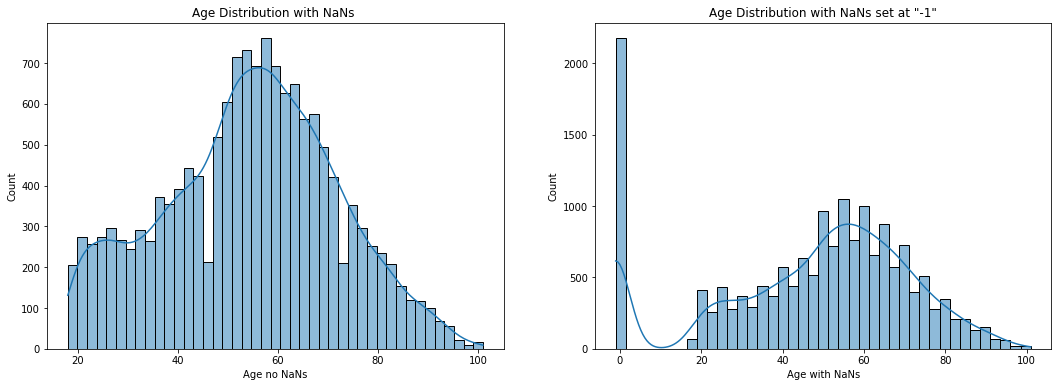

In [40]:
import seaborn as sns


def plot_age(profile):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    age_profile_no_nans = (
        profile
        # .assign(gender=lambda df: df['age'].fillna(99))
        # .groupby('age')
        # .count()
        [['age']]
        .rename(columns=lambda _: 'Age no NaNs')
        .dropna()
    )
    age_profile_with_nan = (
        profile
        .assign(age=lambda df: df['age'].fillna(-1))
        # .groupby('age')
        # .count()
        [['age']]
        .rename(columns=lambda _: 'Age with NaNs')
    )
    splots = []
    splots.append(sns.histplot(
        data=age_profile_no_nans,
        x = 'Age no NaNs',
        kde=True,
        ax=axs[0]
    ))
    splots.append(sns.histplot(
        data=age_profile_with_nan,
        x = 'Age with NaNs',
        kde=True,
        ax=axs[1],
    ))
    splots[0].set_title('Age Distribution with NaNs ')
    splots[1].set_title('Age Distribution with NaNs set at "-1"')
    return splots

plot_age(profile);

In [121]:
# TODO FIXME <HERE>

In [112]:
age_profile_no_nans

,Age no NaNs
age,
18.0,70
19.0,135
20.0,135
21.0,140
22.0,131
...,...
97.0,13
98.0,5
99.0,5


In [89]:
len(profile)

17000

## Data Cleaning Pt 2 - Handling NaNs

## Feature Generation

In [14]:
%autoreload 2
from capstone_tools.enums import Event
from capstone_tools.feature_generation import transform

In [18]:
transcript_tx = transform(
    clean_dataframes['transcript'],
    'transcript',
    portfolio=clean_dataframes['portfolio']
)

KeyboardInterrupt: 

In [ ]:
transcript_tx

In [147]:
transcript.event.unique()

['offer received', 'offer viewed', 'transaction', 'offer completed']
Categories (4, object): ['offer completed', 'offer received', 'offer viewed', 'transaction']

In [155]:
completed_offers = transcript.query(f"event == '{Event.completed}'")


In [156]:
first_id = completed_offers.iloc[0]

In [157]:
first_id

person      9fa9ae8f57894cc9a3b8a9bbe0fc1b2f
event                        offer completed
time                                       0
offer_id    2906b810c7d4411798c6938adc9daaa5
reward                                   2.0
amount                                   NaN
Name: 12658, dtype: object

In [158]:
first_id.person

'9fa9ae8f57894cc9a3b8a9bbe0fc1b2f'

In [160]:
transcript.query(f"event == '{Event.received}'").query(f"person == '{first_id.person}' and offer_id == '{first_id.offer_id}'")

,person,event,time,offer_id,reward,amount
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN


In [161]:
transcript.query(f"event == '{Event.viewed}'").query(f"person == '{first_id.person}' and offer_id == '{first_id.offer_id}'")

,person,event,time,offer_id,reward,amount
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN


In [162]:
transcript.query(f"event == '{Event.transaction}'").query(f"person == '{first_id.person}'")

,person,event,time,offer_id,reward,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,<NA>,NaN,34.56
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,42,<NA>,NaN,21.55
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,114,<NA>,NaN,32.87
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,156,<NA>,NaN,19.99
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,168,<NA>,NaN,20.97
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,204,<NA>,NaN,31.09
132814,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,354,<NA>,NaN,18.42
145382,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,390,<NA>,NaN,29.71
147220,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,396,<NA>,NaN,32.53
148933,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,402,<NA>,NaN,33.36


In [163]:
len(transcript.person.unique())

17000

In [164]:
transcript.query(f"person == '{first_id.person}'")

,person,event,time,offer_id,reward,amount
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,<NA>,NaN,34.56
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,42,<NA>,NaN,21.55
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,114,<NA>,NaN,32.87
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,156,<NA>,NaN,19.99
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,168,<NA>,NaN,20.97
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,204,<NA>,NaN,31.09
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN


In [ ]:
%autoreload 2
from capstone_tools import feature_generation

In [95]:
df.query("event == 'offer completed'")

,person,event,time,offer_id,reward,amount,offer_duration,offer_start,offer_elapsed_time,offer_is_valid,offer_viewed
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,5.0,408.0,6.0,False,True
228423,0009655768c64bdeb2e877511632db8f,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,10.0,504.0,24.0,False,True
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,7.0,576.0,0.0,True,True


In [94]:
p, df = next(iter(df.groupby('person')))
df

,person,event,time,offer_id,reward,amount,offer_duration,offer_start,offer_elapsed_time,offer_is_valid,offer_viewed
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,3.0,168.0,0.0,True,NaN
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,3.0,168.0,24.0,False,True
89291,0009655768c64bdeb2e877511632db8f,transaction,228,<NA>,NaN,22.16,3.0,168.0,60.0,False,True
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,4.0,336.0,0.0,True,True
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,4.0,336.0,36.0,False,True
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,408.0,0.0,True,True
168412,0009655768c64bdeb2e877511632db8f,transaction,414,<NA>,NaN,8.57,5.0,408.0,6.0,False,True
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,5.0,408.0,6.0,False,True
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,408.0,48.0,False,True
204340,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10.0,504.0,0.0,True,True


In [59]:
transcript.query("event == 'offer completed'").query(f"person == '{first_id.person}' and offer_id == '{first_id.offer_id}'")

,person,event,time,offer_id,reward,amount
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2.0,NaN


In [60]:
first_id.offer_id

'2906b810c7d4411798c6938adc9daaa5'

In [61]:
portfolio.query(f"id == '{first_id.offer_id}'")

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [62]:
transcript.query(f"person == '{first_id.person}'")

,person,event,time,offer_id,reward,amount
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,<NA>,NaN,34.56
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,42,<NA>,NaN,21.55
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,114,<NA>,NaN,32.87
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,156,<NA>,NaN,19.99
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,168,<NA>,NaN,20.97
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,204,<NA>,NaN,31.09
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN


## Removing Bad Values